# Mini-Project 1: Galaxy Clusters & Velocity

**Context**

This notebook illustrates the basics of accessing a galaxy catalog from N-body simulations through Apache Spark as well as how to select useful samples of data to study galaxy clusters. Data would be representative (although we will play with a very small set) to LSST simulations data. For more about Apache Spark in the context of LSST connect to [AstroLab Software](https://astrolabsoftware.github.io/)!

**Learning objectives**

After going through this notebook, you should be able to:

- Load and efficiently access a galaxy catalog with Apache Spark
- Apply cuts to the catalog using Spark SQL functionalities
- Have several example of quality cuts and validation procedures 
- Derive scientific results on galaxy clusters
- Distribute the computation and the plotting routine to be faster!

In [2]:
from typing import Iterator, Generator, Any

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

from scipy.optimize import curve_fit

from pyspark.sql.functions import pandas_udf , PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

## Loading data with Spark

Let's load the `data/catalogs` data set:

In [3]:
# Path to the data
fn = "../../data/catalogs"

# Load the data - this a lazy operation, no data movement yet!
df = spark.read.format("parquet").load(fn)

# Let's inspect the schema
df.printSchema()

# Number of objects in the catalog
print("Number of rows: {}".format(df.count()))

root
 |-- velocity_z: float (nullable = true)
 |-- ra: float (nullable = true)
 |-- mag_g: float (nullable = true)
 |-- spheroidMassStellar: float (nullable = true)
 |-- totalMassStellar: float (nullable = true)
 |-- redshift: float (nullable = true)
 |-- hostHaloMass: float (nullable = true)
 |-- halo_mass: float (nullable = true)
 |-- velocity_y: float (nullable = true)
 |-- velocity_x: float (nullable = true)
 |-- baseDC2/target_halo_mass: float (nullable = true)
 |-- stellar_mass: float (nullable = true)
 |-- diskMassStellar: float (nullable = true)
 |-- stellar_mass_bulge: float (nullable = true)
 |-- position_z: float (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- is_central: boolean (nullable = true)
 |-- dec: float (nullable = true)
 |-- stellar_mass_disk: float (nullable = true)
 |-- position_x: float (nullable = true)
 |-- position_y: float (nullable = true)
 |-- mag_u: float (nullable = true)
 |-- blackHoleMass: float (nullable = true)
 |-- mag_i: float (nullabl

Let's have a look a some mass values. Apache Spark provides filter mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset:

In [4]:
# We reject synthetic halos (negative halo_id) that are added to host the ultra-faint galaxies
cols = ["halo_mass", "stellar_mass", "blackHoleMass", "halo_id"]
df.filter("halo_id > 0").select(cols).show(5)

+-------------+------------+-------------+----------+
|    halo_mass|stellar_mass|blackHoleMass|   halo_id|
+-------------+------------+-------------+----------+
| 4.4350804E10|    3.6413E7|          0.0|1800097475|
|1.57075833E11|  6.348809E8|          0.0|2900097475|
| 8.1309388E11|1.49944512E8|    167710.17|6900097475|
|  3.880695E10|1.40301936E8|    39764.223|7400097475|
|1.64282866E12| 6.0976064E8|     788019.0|7500097475|
+-------------+------------+-------------+----------+
only showing top 5 rows



Note that `halo_mass` is duplicated for all the members of the same halo. 
We can also easily look at statistics about individual columns:

In [5]:
# Let's look at the stellar_mass and halo_mass distributions
df.select(["stellar_mass", "halo_mass", "redshift"]).describe().show(5)

+-------+-------------------+--------------------+------------------+
|summary|       stellar_mass|           halo_mass|          redshift|
+-------+-------------------+--------------------+------------------+
|  count|            1723590|             1723590|           1723590|
|   mean|4.392774800421068E8|2.457435238444846...|1.8692950652812128|
| stddev|5.675334970959427E9| 4.58145486379016E12|0.7113005442763203|
|    min|           9495.529|         6.3095736E9|       0.011708259|
|    max|        9.177299E11|       4.51343114E14|         3.0785534|
+-------+-------------------+--------------------+------------------+



## Halo mass distribution

To start this journey, let's look at the distribution of halo masses in the catalog.

**Exercise (£):** Create 3 DataFrames from `df` with different populations:
- Full data set (all redshift)
- low-z (0.0 < z < 0.2) clusters
- high-z (2.5 < z < 3.1) clusters

In the three cases, you will select only central galaxies, and clusters with positive `halo_id` (i.e. we reject the synthetic halos that are added to host the ultra-faint galaxies). (hint: to speed up the computation, do not forget cache capabilities!)

In [6]:
# We cache the data for speeding up later computations
df_mass = df.filter('is_central == True').filter("halo_id > 0").select("halo_mass").cache()

# Populations based on redshift range
df_mass_lowz = df_mass.filter("redshift < 0.5")
df_mass_highz = df_mass.filter("redshift > 2.5")

Since the number of clusters is rather high, we will capitalize on the fact that we are doing computation in parallel.
The way to be faster is to distribute the computation which leads to the data to be plotted. Histograms are particularly easy to distribute:
- Load the data set (distributed accross machines)
- Apply filters on lines and select columns (order does not matter as Spark will choose the optimal way). Partitions will be processed in parallel. If you have more partitions than workers (typically CPU), there will be a partition queue.
- With the remaining data in each partition, build an histogram per partition.
- Reduce to the driver all partition histograms by summing them up. You have the final histogram!

**Exercise (£££):** Write such a method to be applied on each Spark partition to compute histograms in parallel (each would contain only a fraction of the data). Hint: `mapPartitions` and `numpy` could be your friends.

In [7]:
def partition_hist(partition: Iterator, bins : np.ndarray = None) -> Generator:
    """ Produce histograms from partition data
    
    Parameters
    ----------
    partition : Iterator
        Iterator containing partition data *[x].
        
    Returns
    ----------
    Generator yielding histograms for each partition. 
    Counts is an array of dimension nbins - 1.
    """
    # Unwrap the iterator
    mass = [*partition]
    
    (counts, edges) = np.histogram(mass, bins)
    
    yield counts

def parallel_hist(df: DataFrame, bins : np.ndarray, col: str = None) -> np.ndarray:
    """ Build an histogram of the data in parallel
    
    Parameters
    ----------
    df : DataFrame
        Apache Spark DataFrame.
    bins : 1D numpy array
        The bin edges, including the rightmost edge.
    col : str, optional
        Column to select. If None, the DataFrame is
        expected to have only one column. Default is None.
        
    Returns
    ----------
    hist : 1D numpy array
        Full histogram over `bins` for the selected DataFrame column.
        hist has dimension len(bins) - 1.

    """
    # Go from DataFrame to RDD world
    if col is None:
        rdd = df.rdd
    else:
        rdd = df.select(col).rdd
        
    # Build the histograms in each partition
    hist = rdd\
        .mapPartitions(lambda partition: partition_hist(partition, bins))\
        .reduce(lambda x, y: x+y)

    return hist

# Binning of mass in log space
bins = np.logspace(8, 15, 50)

# Build histograms for the 3 populations
dataplot = []
for index, dataframe in enumerate([df_mass, df_mass_lowz, df_mass_highz]):
    # This is the crucial part - build the plot data in parallel, and
    # reduce the final result to the driver. Scalable to Billions of points!
    dataplot.append(parallel_hist(dataframe, bins))

Entries for All redshifts : 186260 (100.0%)
Entries for 0.0 < z < 0.5 : 6417 (3.4%)
Entries for 2.5 < z < 3.1 : 35815 (19.2%)


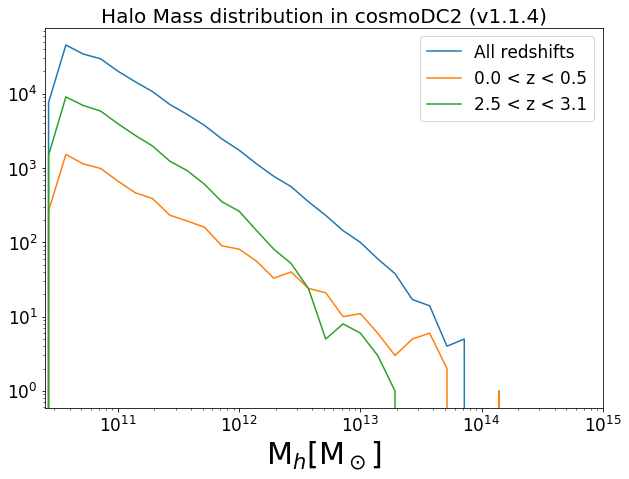

In [8]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
labels = ["All redshifts", "0.0 < z < 0.5", "2.5 < z < 3.1"]

fig = plt.figure(figsize=(10, 7))
for index in range(len(dataplot)):
    plt.loglog(bins[:-1], dataplot[index], label=labels[index])
    print('Entries for {} : {} ({:.1f}%)'.format(
        labels[index], 
        np.sum(dataplot[index]), 
        np.sum(dataplot[index])/np.sum(dataplot[0])*100))
plt.legend()

plt.xlim(2.5e10, 1e15)
plt.title('Halo Mass distribution in cosmoDC2 (v1.1.4)', fontsize=20)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.show()

### A weird feature!

We selected the clusters based on their `halo_id`, and to avoid double counting we took only entries corresponding to central galaxies (all galaxies for a given `halo_id` have the same `halo_mass`).

**Exercise (£):** Inspect the `halo_mass` distribution values. What do you observe? Hint: did you see the attack of the clones?

In [9]:
df1 = df.filter('is_central == True').filter("halo_id > 0").select('halo_mass')
df2 = df.filter('is_central == True').filter("halo_id > 0").select('halo_mass').distinct()

print("All halo_mass values: {}".format(df1.count()))
print("All distinct halo_mass values: {}".format(df2.count()))

All halo_mass values: 186260
All distinct halo_mass values: 2585


There many different halos (i.e. different position on sky) with exactly the same mass! Note that we already select central galaxies to grab the value of the halo mass. Let's look at both distributions:

In [10]:
# Build plots in parallel - millions of points!
data1 = parallel_hist(df1, bins)
data2 = parallel_hist(df2, bins)

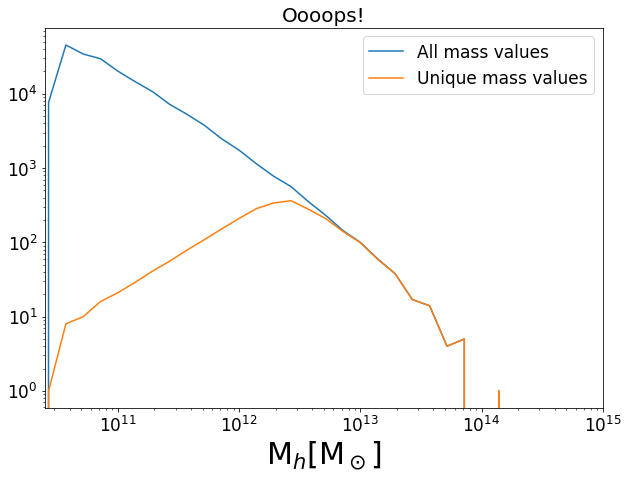

In [11]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
plt.figure(figsize=(10, 7))
plt.loglog(bins[:-1], data1, label="All mass values")
plt.loglog(bins[:-1], data2, label="Unique mass values")
plt.title("Oooops!", fontsize=20)
plt.xlim(2.5e10, 1e15)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.legend()
plt.show()

That means many halos with mass lower than $10^{13} {\rm M}_\odot$ have the same mass.

**Question**: Is that expected?

**Answer:** Yes! This is the so-called mass quantization in N-body simulations: all halo masses must by definition be some integer times the particle mass value used in the simulations (a few times 10^9 solar masses).

## Galaxy clusters and velocity in DC2

### A few individual galaxy clusters

Let's now focus on some selected galaxy clusters. 

**Exercise (£):** Extract 5 rich clusters ($n_{gal} > 20$).

In [12]:
# We reject synthetic halos 
df_halo = df.filter("halo_id > 0")

# Group by halo_id, and count members
df_halo_grouped = df_halo.groupBy("halo_id").count().filter("count > 20")
df_halo_grouped.show(5)

# Take the 5 first
halos = df_halo_grouped.select("halo_id").take(5)

+-------------+-----+
|      halo_id|count|
+-------------+-----+
| 182700097315|   36|
| 385000097365|   24|
| 505900097373|   21|
|  95600097373|   51|
|1706500097279|   21|
+-------------+-----+
only showing top 5 rows



### Mean velocity as a function of redshift

To end this journey, let's have a look at the mean velocity distribution as a function of redshift:

In [13]:
# Redshift range
redshift_start = 0.0
redshift_stop = 3.0
redshift_step = 0.5
redshift_window = 0.1
values = np.arange(redshift_start, redshift_stop, redshift_step)

# start at 0.2 because stat is poor at very low redshift
values[0] = 0.2

**Exercise (££):** Make histograms of the mean 3D velocity of haloes, at different redshift ranges. Hint: look at `groupBy` and `agg`.

In [17]:
pdfs = []
for index, start in enumerate(values[:]):
    dfcut = df.filter("halo_id > 0").filter("redshift > {}".format(start))\
        .filter("redshift <= {}".format(start + redshift_window))
    
    # Group data by halos and compute the mean velocity
    df_disp = dfcut.groupBy("halo_id").agg({
        "velocity_x": 'mean',
        "velocity_y": 'mean',
        "velocity_z": 'mean'})

    # Add back original columns, and 
    # select only a few columns for the plot
    data_joined = dfcut.join(df_disp, "halo_id")\
        .filter("is_central == True")\
        .select("avg(velocity_x)", "avg(velocity_y)", 'avg(velocity_z)')
    pdfs.append(data_joined.toPandas())

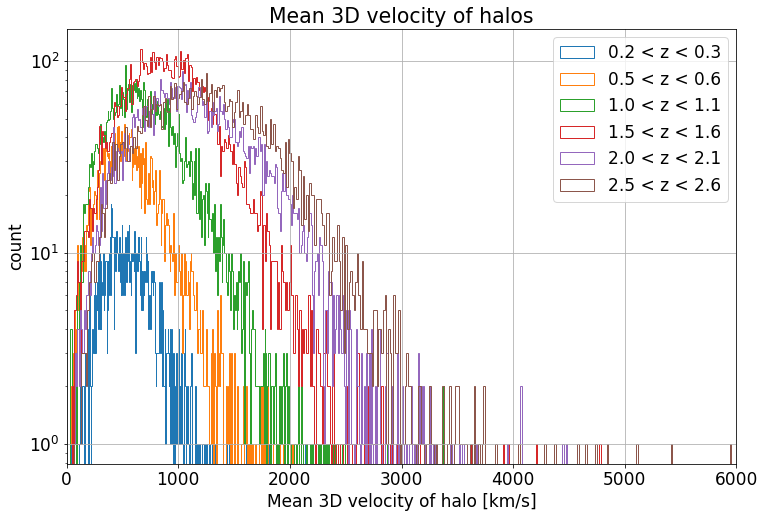

In [18]:
matplotlib.rcParams.update({'font.size': 17})
fig = plt.figure(figsize=(12, 8))

plt.title("Mean 3D velocity of halos")
for index, pandas_df in enumerate(pdfs):
    # simple mean
    meanv = np.sqrt(
        pandas_df["avg(velocity_x)"]**2 + 
        pandas_df["avg(velocity_y)"]**2 + 
        pandas_df["avg(velocity_z)"]**2)
    
    # histogram
    plt.hist(
        meanv, bins=400, 
        label="{:.1f} < z < {:.1f}".format(values[index], values[index] + redshift_window), 
        histtype="step")

plt.yscale("log")
plt.xlim(0, 6000)

plt.xlabel("Mean 3D velocity of halo [km/s]")
plt.ylabel("count")

plt.legend()
plt.grid()

plt.show()

It is interesting to notice that the peak of the distribution shifts towards larger values for high redshift. The distributions are also broader at high redshift.

## The velocity dispersion–halo mass relation

**Exercise (££££):** compute the velocity dispersion–halo mass relation. The principle is similar to the M-$\sigma$ relation for stars around black holes. The idea is to highlight the fact that gravitational interaction/friction between galaxies has an effect for the cluster galaxy evolution.

Hints:
- Use pandas UDF to compute the 3D velocity norm.
- Use `stddev_pop` combined to `groupBy`.
- Use DataFrame `join` method.

In [19]:
from pyspark.sql.functions import stddev_pop

@pandas_udf('double', PandasUDFType.SCALAR)
def normv(vx: Any, vy: Any, vz: Any) -> pd.Series:
    """ Compute the 3D velocity norm.
    
    To be used as a User Defined Function for Spark.
    
    Parameters
    ----------
    v{i} : 1D array, or string, or DataFrame column
        Velocity data
    
    Returns
    ----------
    One-dimensional ndarray with axis labels (including time series).
    """
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    return pd.Series(v)

# We reject synthetic halos
df_filt = df.filter("halo_id > 0")

# Add a column which is the 3D velocity norm
df_meanv = df_filt\
    .withColumn("normv", normv("velocity_x", "velocity_y", "velocity_z"))\
    .select(["normv", "halo_mass", "is_central", "halo_id", "redshift"])

# Group data by halos and compute the velocity dispersion
df_disp = df_meanv.groupBy("halo_id").agg(stddev_pop("normv").alias("stdv"))

In [20]:
# Add back the original DataFrame columns
# and select only central member for halo 
# (unique halo mass and velocity dispersion for a halo)
data_joined = df_meanv.join(df_disp, "halo_id")\
    .filter("is_central == True")\
    .filter("stdv > 0")\
    .select("stdv", "halo_mass", 'redshift')\
    .dropna()
data_joined.show(5)

# Collect the data from the executors to the driver
data = data_joined.collect()

+-----------------+-------------+----------+
|             stdv|    halo_mass|  redshift|
+-----------------+-------------+----------+
|  3.7957763671875| 6.1351867E11| 2.8446217|
| 12.7696533203125|3.86221801E11| 1.8468219|
|8.775588989257812|1.48085911E13|0.47470096|
|99.36129760742188| 5.7101654E11| 1.6029589|
| 16.6717529296875|4.38877762E12|0.95030105|
+-----------------+-------------+----------+
only showing top 5 rows



In [21]:
vel, mass, redshift = np.transpose(data)
print("Number of entries: {}".format(len(vel)))

Number of entries: 5080


Let's now plot the velocity dispersion vs halo mass

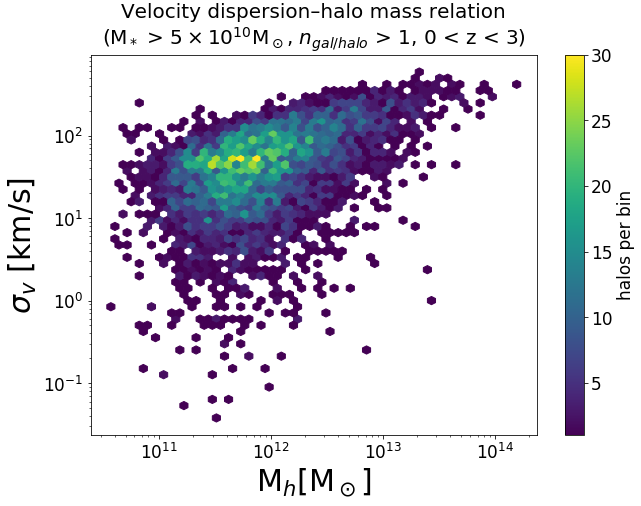

In [22]:
matplotlib.rcParams.update({'font.size': 17})
fig = plt.figure(figsize=(10, 7))

cs = plt.hexbin(mass, vel, gridsize=50, xscale="log", yscale="log", mincnt=1)

plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.ylabel(r'$\sigma_v$ [km/s]', fontsize=30)

plt.colorbar(cs, label="halos per bin")

title = "Velocity dispersion–halo mass relation\n"
hypotheses = r"(${\rm M}_*$ > $5\times10^{10}{\rm M}_\odot$, $n_{gal/halo}$ > 1, 0 < z < 3)"
plt.title(title + hypotheses, fontsize=20)

plt.show()

One can see that there is a good relationship between the two. One can also see regular stripes at some halo masses. Let's inspect the 1D mass distribution:

### To go further: fitting the data

Following e.g. [1602.00611](https://arxiv.org/abs/1602.00611) (see section 4.1), we can model the mean relation between velocity dispersion and halo mass at a given redshift using a simple power-law of the form:

$$\sigma_v(\rm{M}_h) = \alpha \Big( \dfrac{\rm{M}_h}{10^{14}\rm{M}_\odot} \Big)^{\beta}$$

and the dependency in redshift is given by

$$\sigma_v(z) = \sigma_v(0)\sqrt{1 + z}$$